
# EP1 de Programacao Paralela e Distribuída - MAC5742



| Nome | N° USP |
|------|------|
| Ariel Serranoni Soares da Silva| 7658024 |
| Thiago Martinoni | 9793401 |


## Resumo

Em matemática, fractais são conjuntos auto-similares. Intuitivamente essa propriedade significa que, se $X$ é um conjunto
auto-similar, então $X$ é formado por cópias identicas a si mesmo. Não raramente a representação gráfica desses conjuntos se mostra extremamente interessante, se tornando uma porta de entrada muitos que desejam mergulhar no mundo da matemática.
Em particular, o Conjunto de Mandelbrot é um fractal que pode ser vizualizado facilmente através de um algorítmo utilizando apenas conceitos básicos de programação, como condicionais e laços.

A combinação dos motivos citados acima torna este programa um exercício ideal para disciplinas introdutórias de computação. Neste trabalho vamos fazer mais: implementaremos três versões deste algorítmo, a clássica sequencial, uma utilizando PThreads e uma terceira utilizando OpenMp. Além disso, vamos analisar o desempenho de cada programa afim de estudar brevemente o desempenho dessas duas bibliotecas. Os arquivos utilizados para a produção deste estudo encontram-se disponíveis [neste repositório](https://github.com/aserranoni/parallel-mandelbrot).

## Implementações em C

Como mencionamos, temos três programas, cada um responsável por calcular o conjunto de mandelbrot utilizando um método diferente. 
Como o arquivo `mandelbrot_seq.c` serve como base para as paralelizações `mandelbrot_pth.c` e `mandelbrot_omp.c`, é natural 
que comentemos algumas das mudanças que fizemos na implementação do primeiro antes de continuarmos: 

#### Percorrendo vetores multidimensionais com um único laço

Em primeiro lugar, é importante enxergar que a divisão do trabalho de um algorítmo em unidades tão pequenas quanto possível nos oferece uma flexibilidade maior ao alocar tarefas para cada thread, facilitando a paralelização do programa.

Na implementação original que recebemos como base, a função `compute_mandelbrot()` operava com dois laços. Neste contexto,
cada iteração do laço externo era responsável por uma linha da imagem. Portanto, para dividir o trabalho da função em unidades menores do que uma linha, seríamos obrigados a criar threads dentro de threads ou então partir para um novo 
paradigma de implementação do nosso programa. 

A mudança que fizemos foi considerar um único parâmetro `i`, desta vez percorrendo todos os `image_buffer_size` pixels da imagem. Sabendo o número `image_size` de pixels em cada linha, conseguimos descobrir a linha (`i/image_size`) e coluna (`i%image_size`) exatas de um pixel a partir de um único parâmetro. 

Vale notar que esse mesmo raciocínio pode ser generalizado para vetores com mais dimensões (tensores). Por exemplo, 
adicionando uma terceira dimensão, consegueríamos saber a "altura" a qual o índice `i` corresponde ao fazer o cálculo
`i/image_size ^2`.

#### Cálculos de tempo 

Para medir o desempenho de um programa, é essensial que tenhamos uma maneira de medir o tempo de execução do mesmo. 
Para isso, aproveitamos a struct `timer_info` do miniEP3 e encapsulamos as medições feitas na ocasião nas funções `start_timer()` e `stop_timer()`. Também retornamos os resultados utilizando os mesmos métodos no miniEP3 através da função `print_results()`.

#### Recebendo mais opções pela linha de comando

Além da mudança descrita anteriormente, também adicionamos um argumento extra `i_o` a ser recebido na inicialização do programa. Este parâmetro binário é responsável por controlar duas coisas. Caso tenhamos `i_o==1`, contamos o tempo para executar as funções `allocate_image_buffer()` e `write_to_file()`. Caso contrário, a função `write_to_file()` não 
é executada e o tempo da função `allocate_image_buffer()` não é computado. Dessa forma, conseguimos mudar estas opções no programa sem alterar o código, contribuindo para a praticidade na realização do experimento.

### Implementações em paralelo

Nas implementações em paralelo, utilizamos a estratégia de divisão estática tanto no programa `mandelbrot_pth` quanto no `mandelbrot_omp` afim de obter uma comparação tão justa quanto possível. Apesar disso não sabemos exatamente o que a OpenMp faz com
o resto da divisão das unidades de trabalho pelo número de threads. Por outro lado, na implementação utilizando PThreads adicionamos este excedente ao trabalho da primeira thread. 

Por fim, adicionamos a ambos os programas em paralelo mais um parâmetro `n_threads`, representando o número de threads que o programa deve utilizar. Esta mudança também tem o intuito de possibilitar a realização do experimento sem editar os códigos.


## Infra estrutura Julia

Para este relatório, também reaproveitamos muito da estrutura dos trabalhos anteriores. Utilizamos Jupyter notebooks e Julia na versão 1.3.0. Também usamos os mesmos pacotes do nosso último trabalho. A seguinte célula fará as instalações necessárias dos pacotes Julia:  

In [1]:
]up

  Updating registry at `~/.julia/registries/General`
  Updating git-repo `https://github.com/JuliaRegistries/General.git`
 Resolving package versions...
  Updating `/var/fasttmp/parallel-mandelbrot/src/Project.toml`
 [no changes]
  Updating `/var/fasttmp/parallel-mandelbrot/src/Manifest.toml`
  [aaaa29a8] ↑ Clustering v0.13.4 ⇒ v0.14.0
  [b4f34e82] ↓ Distances v0.9.0 ⇒ v0.8.2
  [b8a86587] ↓ NearestNeighbors v0.4.5 ⇒ v0.4.4


Antes de iniciarmos os experimentos, vale conferir se tudo correu como esperado na instalação acima.

In [2]:
] st

    Status `/var/fasttmp/parallel-mandelbrot/src/Project.toml`
  [336ed68f] CSV v0.6.2
  [a93c6f00] DataFrames v0.21.2
  [31c24e10] Distributions v0.23.3
  [38e38edf] GLM v1.3.9
  [7073ff75] IJulia v1.21.2
  [8314cec4] PGFPlotsX v1.2.6
  [1a8c2f83] Query v0.12.2
  [f3b207a7] StatsPlots v0.14.6


## Experimentos e Coleta de Dados 

O Primeiro passo para analisarmos o tempo de execução de um determinado software sempre foi e sempre será executar o programa
em questão. A função abaixo é uma adaptação da função `measure_monte_carlo()` do mini EP3. Seu objetivo é justamente fazer uma chamada de um dos programas em C na linha de comando e salvar os dados que serão relevantes para nossa análise.

A função `mandelbrot()` recebe 5 argumentos: 

O primeiro argumento `method` é uma string que determina qual das implementações
em C deve ser chamada. Os valores possíveis para esta variável são `"seq"`, `"pth"`, e `"omp"`. 

O segundo argumento `region` é uma
entrada de um dicionário cuja "chave" para uma entrada é uma string e a entrada em si é uma 4-tupla.

O terceiro argumento `image_size` é um inteiro que, assim como nas implementações em C determina o tamanho, em pixels,
do lado da imagem a ser produzida.

O quarto argumento `i_o` também é um inteiro que tem a mesma utilidade descrita anteriormente.

O quinto e último argumento `threads` é opcional e também tem o mesmo objetivo descrito acima.


In [3]:
using DataFrames, Query, StatsPlots, Statistics

function mandelbrot(method, region, image_size, i_o, threads=1)
    a=region[2][1]
    b=region[2][2]
    c=region[2][3]
    d=region[2][4]
    results = parse.(Float64,
        split(chomp(read(`./mandelbrot_$method $a  $b $c $d $image_size $i_o $threads`, String)), ", "))
        
    return DataFrame(size = image_size,
                region=region[1],
                delta_x = region[2][2] - region[2][1],
                delta_y = region[2][4] - region[2][3],
                duration_clock = results[1],
                duration_mono = results[2],
                duration_sys = results[3],
                threads=threads,
                method=method,
                i_o=i_o)
    end

┌ Info: Precompiling DataFrames [a93c6f00-e57d-5684-b7b6-d8193f3e46c0]
└ @ Base loading.jl:1273
┌ Info: Precompiling StatsPlots [f3b207a7-027a-5e70-b257-86293d7955fd]
└ @ Base loading.jl:1273


mandelbrot (generic function with 2 methods)

Para que nossa análise tenha algum valor do ponto de vista estatístico, precisamos nos basear em uma amostra consideravelmente
grande. A função a seguir, também adaptada do miniEP3, tem o intuito de automatizar repetidas chamadas dos programas em C, feitas pela função acima. 

A função `run_experiments()` a seguir nos permite variar todos os parâmetros das chamadas feitas pela função `mandelbrot()` e estabelecer um número de repetições através do através do argumento `repetitions`. Então as chamadas são executadas, os resultados coletados e retornados na forma de um `DataFrame`.


In [4]:
function run_experiments(methods, regions ,image_size, threads, i_o, repetitions)
    run(`make`)
    
    results = DataFrame(size = Int64[],
                region = String[],
                delta_x = Float64[],
                delta_y = Float64[],
                duration_clock = Float64[],
                duration_mono = Float64[],
                duration_sys = Float64[],
                threads= Int64[],
                method= String[],
                i_o = Int64[])
        
    for tuple in regions
        for method in methods
            for size in image_size
                for t in 1:length(threads)
                    if ( threads[t] <= 1  || method != "seq") 
                            if(method == "seq")
                                for alt in i_o
                                    for r in 1:repetitions
                                        append!(results, mandelbrot(method, tuple, size, alt, threads[t]))
                                    end
                                end
                            end
                            if(method !="seq")
                                for r in 1:repetitions
                                    append!(results, mandelbrot(method, tuple, size, 0, threads[t]))
                                end
                            end
                        end
                    end
                end
            end
        end
    return results
end
           

run_experiments (generic function with 1 method)

Antes de iniciar os experimentos, vamos ajustar parâmetros da função `run_experiments()` conforme a tabela abaixo.
É importante alertar que a execução pode ser extremamente demorada (12h+). Por este motivo, optamos por deixar a linha responsável pela execução do experimento comentada.


|               	| Sequencial         	| Pthreads & OpenMp  	| 
|----------------	|--------------------	|--------------------	|
| I/O e Alocação 	| Com e Sem          	| Sem                	|
| N° de Threads  	| 1                  	| $2^0\ldots 2^5$    	|
| Lado da Imagem 	| $2^0\ldots 2^{13}$ 	| $2^0\ldots 2^{13}$ 	|
| Região         	| Todas              	| Todas              	|


In [7]:
using CSV

sizes=[2^x for x in 4:13]
threads = [2 ^ x for x in 0:5]
methods = ["pth","omp","seq"]
i_o=[0,1]
regions = Dict("Full Picture" => (-2.5,1.5,-2.0,2.0),
                "Seahorse Valley" => (-0.8,-0.7,0.05,0.15),
                "Elephant Valley" => (0.175,0.375,-0.1,0.1),
                "Triple Spiral Valley" =>(-0.188,-0.012,0.554,0.754))
repetitions=10
#results = run_experiments(methods, regions, sizes, threads, i_o, repetitions)
#CSV.write("./results.csv",results,delim='\t')
results =CSV.read("results.csv")

,size,region,delta_x,delta_y,duration_clock,duration_mono,duration_sys
,Int64,String,Float64,Float64,Float64,Float64,Float64
1,16,Full Picture,4.0,4.0,0.000378,0.010991,0.010989
2,16,Full Picture,4.0,4.0,0.000382,0.007096,0.007095
3,16,Full Picture,4.0,4.0,0.000378,0.010996,0.010995
4,16,Full Picture,4.0,4.0,0.000428,0.006912,0.00691
5,16,Full Picture,4.0,4.0,0.000388,0.006892,0.006891
6,16,Full Picture,4.0,4.0,0.000431,0.00694,0.006938
7,16,Full Picture,4.0,4.0,0.000241,0.00279,0.002788
8,16,Full Picture,4.0,4.0,0.00021,0.002755,0.002754
9,16,Full Picture,4.0,4.0,0.000232,0.005886,0.005884


Com os parâmetros acima, a função `run_experiments()` realiza 5600 chamadas na linha de comando, gerando um `DataFrame` com
o mesmo número de linhas. A função a seguir irá nos ajudar fazendo uma primeira filtragem nos dados, computando algumas estatísticas que serão importantes na análise a seguir.

In [ ]:
function parse_results(results)
  parsed_results=results|>
                @groupby((_.threads,_.method,_.region, _.size,_.i_o)) |>
                @map({threads_method = key(_),
                repetitions=repetitions,
                delta_x = mean(_.delta_x),
                delta_y = mean(_.delta_y),
                mean_duration_clock = mean(_.duration_clock),
                mean_duration_mono = mean(_.duration_mono),
                mean_duration_sys = mean(_.duration_sys),
                ci_duration_clock = 1.96 * std(_.duration_clock),
                ci_duration_mono = 1.96 * std(_.duration_mono),
                ci_duration_sys = 1.96 * std(_.duration_sys)})|>
                DataFrame
    
      final_results = DataFrame(i_o=Int64[],
                    threads= Int64[],
                    method= String[],
                    region = String[],
                    size = Int64[],
                    delta_x = Float64[],
                    delta_y = Float64[],
                    mean_duration_clock = Float64[],
                    mean_duration_mono = Float64[],
                    mean_duration_sys = Float64[],
                    ci_duration_clock = Float64[],
                    ci_duration_mono = Float64[],
                    ci_duration_sys = Float64[],
                    repetitions = Int64[])
    
        for i in 1:length(parsed_results.threads_method)
            
            append!(final_results, DataFrame(size=parsed_results.threads_method[i][4],
                                        delta_x=parsed_results.delta_x[i],
                                         delta_y=parsed_results.delta_y[i],
                                        mean_duration_clock=parsed_results.mean_duration_clock[i],
                                        mean_duration_mono=parsed_results.mean_duration_mono[i],
                                        mean_duration_sys=parsed_results.mean_duration_sys[i],
                                        ci_duration_clock=parsed_results.ci_duration_clock[i],
                                        ci_duration_mono=parsed_results.ci_duration_mono[i],
                                        ci_duration_sys=parsed_results.ci_duration_sys[i],
                                        repetitions =parsed_results.repetitions[i],
                                        threads = parsed_results.threads_method[i][1],
                                        method = parsed_results.threads_method[i][2],
                                        region = parsed_results.threads_method[i][3],
                                        i_o = parsed_results.threads_method[i][5]))
    
        end
    return final_results
end

Vamos finalmente executar a função acima passando nossos resultados como argumento e salvar a saída como um arquivo CSV:

In [10]:
parsed_results = parse_results(results)
CSV.write("./parsed_results.csv",parsed_results,delim='\t')
parsed_results=CSV.read("parsed_results.csv")

,i_o,threads,method,region,size,delta_x,delta_y,mean_duration_clock
,Int64,Int64,String,String,Int64,Float64,Float64,Float64
1,0,1,pth,Full Picture,16,4.0,4.0,0.0003328
2,0,2,pth,Full Picture,16,4.0,4.0,0.0004125
3,0,4,pth,Full Picture,16,4.0,4.0,0.0006565
4,0,8,pth,Full Picture,16,4.0,4.0,0.0009823
5,0,16,pth,Full Picture,16,4.0,4.0,0.0016383
6,0,32,pth,Full Picture,16,4.0,4.0,0.0031388
7,0,1,pth,Full Picture,32,4.0,4.0,0.0005424
8,0,2,pth,Full Picture,32,4.0,4.0,0.0006329
9,0,4,pth,Full Picture,32,4.0,4.0,0.0008509


## Vizualização e Análise dos Resultados



### Impacto do I/O e Alocação
Vamos iniciar nossa discussão sobre os resultados do experimento analisando o impacto da execução das funções `allocate_image_buffer()` e `write_to_file()` no tempo total de execução do programa `mandelbrot_seq`. É importante ressaltar que, como nas três versões do algorítmo a execução das funções em questão é independente do método utilizado, espera-se que este impacto seja o mesmo para todos os três programas.

O primeiro passo será fazer uma filtragem nos dados, utilizaremos a variável `method` para escolher apenas as linhas
de `parsed_results` tais que `method=="seq"`, obtendo o `DataFrame` `data_seq`. Em seguida, vamos filtrar `data_seq` por região. Finalmente vamos produzir alguns gráficos descrevendo como a média do tempo de execução
evolui conforme aumentamos o parâmetro `image_size` para cada uma das regiões dadas no enunciado.

Também é importante destacar que decidimos utilizar a medição feita pela função em C `clock_gettime()` como padrão em toda a análise feita a seguir.

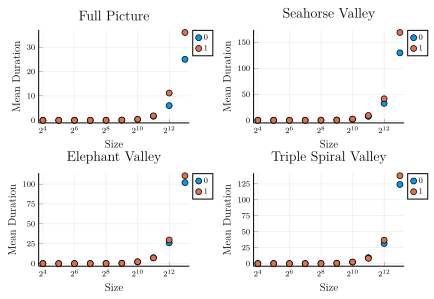

In [48]:
pgfplotsx()
## Data wrangling - Vamos medir o impacto do I/O - Aloc

data_seq = parsed_results[parsed_results.method .== "seq",:]
seq_full = data_seq[data_seq.region .=="Full Picture",:]
seq_seahorse = data_seq[data_seq.region .=="Seahorse Valley",:]
seq_elephant = data_seq[data_seq.region .== "Elephant Valley",:]
seq_spiral = data_seq[data_seq.region .== "Triple Spiral Valley",:]

## Individual plots

p_full=scatter(seq_full.size,
            seq_full.mean_duration_mono,
            title = "Full Picture",
            xlabel="Size",
            ylabel="Mean Duration",
            xaxis=:log2,
            group=seq_full.i_o)

p_seahorse=scatter(seq_seahorse.size,
            seq_seahorse.mean_duration_mono,
            xlabel="Size",
            xaxis=:log2,
            ylabel="Mean Duration",
            title= "Seahorse Valley",
            group=seq_seahorse.i_o)

p_elephant=scatter(seq_elephant.size,
                    seq_elephant.mean_duration_mono,
                    xlabel="Size",
                    xaxis=:log2,
                    ylabel="Mean Duration",
                    title ="Elephant Valley",
                    group=seq_elephant.i_o)

p_spiral = scatter(seq_spiral.size,
                    seq_spiral.mean_duration_mono,
                    xlabel="Size",
                    xaxis=:log2,
                    ylabel="Mean Duration",
                    title="Triple Spiral Valley",
                    group=seq_spiral.i_o)

# Layout

plot(p_full,p_seahorse,p_elephant,p_spiral, layout=(2,2))

Os gráficos acima mostram que, em todas as regiões, há diferença no tempo médio de execução quando incluímos as funções `allocate_image_buffer()` e `write_to_file()` na medição, principalmente para imagens com tamanho grande. Entretanto, é visível que tanto esta diferença quanto o tempo total de execução variam bastante de acordo com a região. 

Vamos estudar essa diferença com um pouco mais de detalhe: a seguir temos gráficos que também mostram o tempo médio 
de execução varia conforme aumentamos o tamanho do lado da imagem. Entretanto, desta vez separamos as vizualizações para os casos  `i_o==1` e `i_o==0` e incluímos os intervalos de confiança correspondentes. 

O objetivo é verificar se, além do tempo médio, a variabilidade no tempo de execução também é afetada pelas funções mencionadas.


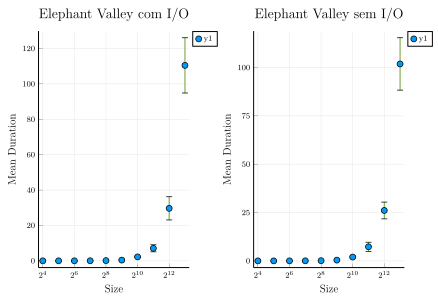

In [130]:
##Individual Plots

r="Elephant Valley"

conf_plot_io=scatter(data_seq_io[data_seq_io.region.==r,:].size,
                    xaxis=:log2,
                     xlabel="Size",
                    ylabel="Mean Duration",
                    data_seq_io[data_seq_io.region.==r,:].mean_duration_mono,
                    yerror=data_seq_io[data_seq_io.region.==r,:].ci_duration_mono,
                    title="$r com I/O")

conf_plot_n_io=scatter(data_seq_n_io[data_seq_n_io.region.==r,:].size,
                    data_seq_n_io[data_seq_n_io.region.==r,:].mean_duration_mono,
                    xlabel="Size",
                    ylabel="Mean Duration",
                    xaxis=:log2,
                    yerror=data_seq_n_io[data_seq_n_io.region.==r,:].ci_duration_mono,
                    title ="$r sem I/O")

plot(conf_plot_io,conf_plot_n_io)

Com as vizualizações acima conseguimos observar que nem toda a variabilidade pode ser explicada a partir do cálculo de Mandelbrot. Ou seja, a variabilidade no tempo de execução também aumenta quando incluímos as funções asocciadas ao parâmetro `i_o`. 


### Desempenho das Paralelizações

Agora vamos analisar a performance das nossas paralelizações. A intenção da vizualização a seguir é dar uma 
primeira ideia de como o tempo de execução dos programas é afetado pela variação nos parâmetros `n_threads` e `image_size`.

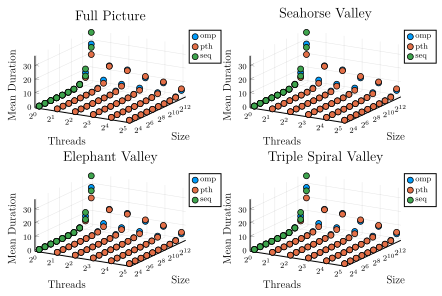

In [103]:
## Little data wrangling

data_full_picture = parsed_results[parsed_results.region .== "Full Picture",:]
data_seahorse_valley = parsed_results[parsed_results.region .== "Seahorse Valley" ,:]
data_elephant_valley = parsed_results[parsed_results.region .== "Elephant Valley", :]
data_triple_spiral = parsed_results[parsed_results.region .== "Triple Spiral Valley", :]

##Plots
p1=scatter(data_full_picture.threads,
            data_full_picture.size,
            xaxis=:log2,
            yaxis=:log2,
            xlabel="Threads",
            ylabel="Size",
            data_full_picture.mean_duration_mono,
            zlabel="Mean Duration",
            group=data_full_picture.method,
            title="Full Picture")

p2=scatter(data_seahorse_valley.threads,
            data_seahorse_valley.size,
            xaxis=:log2,
            yaxis=:log2,
            xlabel="Threads",
            ylabel="Size",
            data_full_picture.mean_duration_mono,
            zlabel="Mean Duration",
            group=data_seahorse_valley.method,
            title="Seahorse Valley")

p3=scatter(data_elephant_valley.threads,
                data_elephant_valley.size,
                xaxis=:log2,
                yaxis=:log2,
                xlabel="Threads",
                ylabel="Size",
                data_full_picture.mean_duration_mono,
                zlabel="Mean Duration",
                group=data_elephant_valley.method,
                title="Elephant Valley")

p4=scatter(data_triple_spiral.threads,
            data_triple_spiral.size,
            xaxis=:log2,
            yaxis=:log2,
            xlabel="Threads",
            ylabel="Size",
            data_full_picture.mean_duration_mono,
            zlabel="Mean Duration",
            group=data_triple_spiral.method,
            title="Triple Spiral Valley")
##Layout
plot(p1,p2,p3,p4 ,layout=(2,2))

Os gráficos acima dão a entender que, independentemente da região fixada, tanto o tamanho da imagem quanto o número de threads
influenciam no tempo de execução: fixado um valor para `threads`, vemos  que o tempo médio de duração aumenta conforme aumentamos o valor de `size`. Em contrapartida, fixado uma valor para `size` o tempo de execução parece diminuir conforme aumentamos o número de `threads`.

A seguir, vamos verificar se nossa primeira impressãp se confirma. Para tal, estudaremos as seções dos gráficos acima. Primeiro, vamos fixar um valor `s` para a variável `size` e verificar o comportamento dos experimentos em cada região conforme variamos o valor de `threads`.

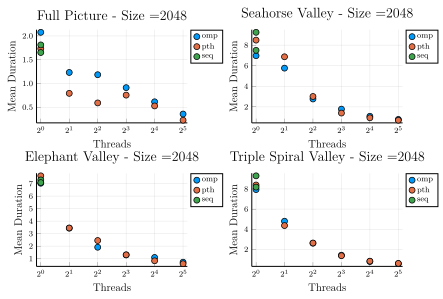

In [112]:
s=2048
data_fps=data_full_picture[data_full_picture.size.==s,:]
data_evs=data_elephant_valley[data_elephant_valley.size.==s,:]
data_shvs=data_seahorse_valley[data_seahorse_valley.size.==s,:]
data_tsvs=data_triple_spiral[data_triple_spiral.size.==s,:]

p_full_fs=scatter(data_fps.threads,
                            data_fps.mean_duration_mono,
                            xlabel="Threads",
                            ylabel="Mean Duration",
                            title = "Full Picture - Size =$s",
                            xaxis=:log2,
                            group=data_fps.method)

p_sh_fs=scatter(data_shvs.threads,
                data_shvs.mean_duration_mono,
                xlabel="Threads",
                ylabel = "Mean Duration",
                title = "Seahorse Valley - Size =$s",
                xaxis=:log2,
                group=data_shvs.method)

p_ev_fs=scatter(data_evs.threads,
                data_evs.mean_duration_mono,
                xlabel="Threads",
                ylabel = "Mean Duration",
                title = "Elephant Valley - Size =$s",
                xaxis=:log2,
                group=data_evs.method)
p_ts_fs=scatter(data_tsvs.threads,
                data_tsvs.mean_duration_mono,
                xlabel="Threads",
                ylabel = "Mean Duration",
                title = "Triple Spiral Valley - Size =$s",
                xaxis=:log2,
                group=data_tsvs.method)
plot(p_full_fs,p_sh_fs,p_ev_fs,p_ts_fs,layout=(2,2))

Com os resultados acima em mãos, podemos ver que, para valores "grandes" (por exemplo $2^{12}$) de `s`, nossa primeira visão das paralelizações concorda com os dados que temos. Isso se deve ao fato de que, com um mesmo total trabalho a ser executado, dividir tarefas entre um número maior de "trabalhadores" tende a diminuir o tempo total que será preciso. Entretanto, quando `s` assume valores "pequenos"(por exemplo $2^4$), o tempo de execução cresce conforme aumentamos do número de threads. Isto occore pois, com pouco trabalho a ser feito, o prejuízo causado pela necessidade de criar threads e alocar tarefas não é compensado pelo ganho em se dividir o trabalho.



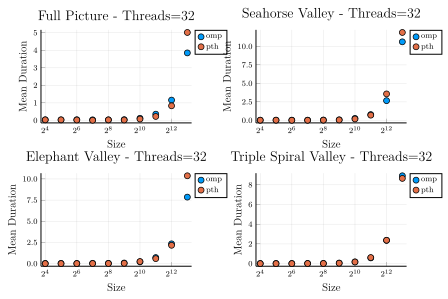

In [116]:
t=32
data_fpt=data_full_picture[data_full_picture.threads.==t,:]
data_evt=data_elephant_valley[data_elephant_valley.threads.==t,:]
data_sht=data_seahorse_valley[data_seahorse_valley.threads.==t,:]
data_tst=data_triple_spiral[data_triple_spiral.threads .==t,:]

p_full_fixed_thread =scatter(data_fpt.size,
                            data_fpt.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Full Picture - Threads=$t",
                            xaxis=:log2,
                            group=data_fpt.method)

p_seahorse_fixed_thread =scatter(data_sht.size,
                            data_sht.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Seahorse Valley - Threads=$t",
                            xaxis=:log2,
                            group=data_sht.method)

p_elephant_fixed_thread =scatter(data_evt.size,
                            data_evt.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Elephant Valley - Threads=$t",
                            xaxis=:log2,
                            group=data_evt.method)

p_spiral_fixed_thread =scatter(data_tst.size,
                            data_tst.mean_duration_mono,
                            xlabel="Size",
                            ylabel="Mean Duration",
                            title="Triple Spiral Valley - Threads=$t",
                            xaxis=:log2,
                            group=data_tst.method)

plot(p_full_fixed_thread,p_seahorse_fixed_thread,p_elephant_fixed_thread,p_spiral_fixed_thread,layout=(2,2))

Mais uma vez, as vizualizações acima confirmam nossa primeira visão sobre o desempenho das paralelizações. Fixado um valor qualquer para a variável `threads`, o tempo médio de execução de ambas as paralelizações aumenta conforme aumentamos o valor de `size`. Isto se deve ao fato de que o aumento da variável size implica em um aumento do total de trabalho que será realizado por cada thread, retardando a execução da mesma. Aumentando o tempo de execução de cada thread, claramente iremos aumentar o tempo total para a execução de um programa. 

### Diferenças entre as regiões

Durante toda a análise acima notamos que, por mais que o comportamento geral dos experimentos fosse o mesmo, temos diferenças,
principalmente de escala, entre as regiões. Pensamos em dois fatores que poderiam hipotéticamente ser responsáveis por tal disparidade.

A primeira hipótese que levantamos é que a causa esteja relacionada à precisão necessária para o cálculo das iterações
em cada região. Isto é, quando dividimos regiões com área pequena em pixels, temos uma "malha mais fina". Nessa situação, o computador provavelmente faz cálculos envolvendo uma precisão maior (mais casas depois da vírgula), retardando o tempo de execução. 

A segunda possibilidade que cogitamos é que algumas regiões do plano incluem pontos cuja norma é maior. Este fato que pode fazer com que o cálculo da cor dos pixels correspondentes aconteca mais rápido. O motivo para isso é que, quanto maior
a norma do ponto correspondente a um píxel $p$, menor é o valor de $k\in\mathbb{N}$ para que $\|f_p^k(0)\|>4$ (onde $f_p(z)=z^2+p$ para quiasquer $p,z\in\mathbb{C}$). Nesse contexto, menos cálculos são precisos para determinar a cor 
correspondente ao pixel $p$.

A seguir, vamos rapidamente verificar se nossos dados contrariam alguma das nossas hipóteses. Primeiro vamos calcular a área de
cada região e a média dos tempos de execução (misturando as três implementações em C). No caso em que as regiões de menor área
tenham menor tempo médio de execução descartamos nossa primeira hipótese.

In [125]:
area_full = seq_full.delta_x[1]*seq_full.delta_y[1]
area_seahorse=seq_seahorse.delta_x[1]*seq_seahorse.delta_y[1]
area_elephant=seq_elephant.delta_x[1]*seq_elephant.delta_y[1]
area_spiral=seq_spiral.delta_x[1]*seq_spiral.delta_y[1]

areas=["Full Picture"=>[area_full,mean(parsed_results[parsed_results.region.=="Full Picture",:].mean_duration_mono)]
        "Seahorse Valley" =>[area_seahorse,mean(parsed_results[parsed_results.region.=="Seahorse Valley",:].mean_duration_mono)]
        "Elephant Valley" =>[area_elephant,mean(parsed_results[parsed_results.region.=="Elephant Valley",:].mean_duration_mono)]
        "Triple Spiral Valley" =>[area_spiral,mean(parsed_results[parsed_results.region.=="Triple Spiral Valley",:].mean_duration_mono)]]


4-element Array{Pair{String,Array{Float64,1}},1}:
         "Full Picture" => [16.0, 1.9946317292857145]               
      "Seahorse Valley" => [0.010000000000000009, 9.652045365714287]
      "Elephant Valley" => [0.039999999999999994, 7.15308674357143] 
 "Triple Spiral Valley" => [0.03519999999999998, 7.704362805714285] 

A partir dos cálculos efetuados acima, vemos que os dados não negam a primeira possibilidade. De fato, vemos que quanto maior
a área de uma região menor será o tempo de execução, como previmos.

Para fazer algum tipo de verificação para nossa segunda hipótese, temos de obter algum parâmetro que indique a norma dos pontos em uma determinada região. Com efeito, para cada região $R$ vamos considerar o parâmetro $p_R$ como o máximo entre as normas dos vértices de $R$. Este número indica que a região $R$ está toda contida na bola centrada em 0 com raio $p_R$.  

In [132]:
norms=DataFrame(region=String[],
                p_r=Float64[],
                mean_duration=Float64[])
for tuple in regions
    max=0
        for i1 in 1:length(tuple[2])
            for i2 in 1:length(tuple[2])
                if i1 != i2
                    norm = tuple[2][i1]^2+tuple[2][i2]^2
                    if norm > max
                            max=norm
                    end
                end
            end
        end
    append!(norms,DataFrame(region=tuple[1],p_r=max,mean_duration=mean(parsed_results[parsed_results.region.==tuple[1],:].mean_duration_mono)))
end
norms

,region,p_r,mean_duration
,String,Float64,Float64
1,Full Picture,10.25,1.99463
2,Seahorse Valley,1.13,9.65205
3,Elephant Valley,0.17125,7.15309
4,Triple Spiral Valley,0.875432,7.70436


In [131]:
cor(norms.norm,norms.mean_duration)

-0.9179483360671918

Os resultados obtidos acima não confirmam nossa segunda hipótese de forma tão óbvia quanto os anteriores confirmam a primeira. Entretanto, calculando o coeficiente de correlação entre as colunas `p_r` e `mean_duration` do Data Frame `norms`, vemos que as variáveis em questão estão altamente relacionadas de maneira inversamente proporcional, como imaginamos. Mais uma vez, não negamos nossa hipótese.

## Observações finais

### Infra Estrutura de trabalho remoto utilizando SSH

A realização deste trabalho demandou muito poder computacional. Como nenhum dos elementos da dupla possui uma máquina adequada para realizar os experimentos pedidos, precisamos aprender um pouco sobre o uso remoto da rede IME. Como
nesse momento em que a grande maioria da comunidade IME não consegue estar fisicamente presente no instituto, resolvemos fazer
uma pequena descrição de como utilizamos a máquina brucutu IV da rede IME para realizar nossos experimentos.

Em primeiro lugar, gostaríamos de agradecer à comunidade, que 
mantém [esta página](https://wiki.ime.usp.br/) com diversas informações úteis, inclusive 
sobre o acesso remoto às redes do IME. Mais especificamente, 
[esta página](https://wiki.ime.usp.br/servicos:processamento) contém uma lista das máquinas do IME com grande poder computacional e orientações de como utilizá-las.

#### Incluindo um novo kernel

Como usuários da rede, não temos as permissões necessárias para instalar, desinstalar, 
nem atualizar os programas disponíveis nas máquinas.
Por exemplo, a versão do Kernel Julia que está disponível na rede IME é a 1.0.3 e não é possível atualizar. Porém, ainda assim
foi possível instalar a versão 1.3.0 do Kernel através do repositório da Linguagem Julia no Github. Ao instalar o pacote `IJulia` nesta nova versão, temos ambas as versões disponíveis no jupyter. É importante lembrarmos que a instalação foi feita na pasta  `/var/tmp/` uma vez que não há espaço suficiente na cota individual de armazenamento. Em suma, por mais que não seja possível utilizar o gerenciador de pacotes `apt`, é possível instalar programas temporariamente através de métodos mais diretos como download de binários ou clonagem de repositórios no GitHub.

#### Abrindo uma porta para acesso local

Mesmo com a interface gráfica de um navegador de internet, ainda temos que lidar com algum tipo de delay, o que torna um tanto desconfortável editar um documento como este. Para resolver este problema, utilizamos o comando

``` ssh -NL [port]:localhost:[port] [seulogin]@brucutuiv.ime.usp.br```

para que possamos acessar o servidor oferecido pelo Jupyter localmente!